In [21]:
import numpy as np
import json
from collections import defaultdict, Counter
from scipy import spatial, stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

In [3]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

# Gender correlation

In [11]:
with open(LOGS + 'semantics_mano/results/scores.json', 'r') as infile: 
    scores = json.load(infile)

vocab_order = []
with open(LOGS + 'semantics_mano/results/vocab_order.txt', 'r') as infile:
    vocab_order = infile.readlines()

with open(LOGS + 'coref_results/mano_gender_labels.json', 'r') as infile: 
    gender_labels = json.load(infile)

-0.5122859198584011 2.5139e-319


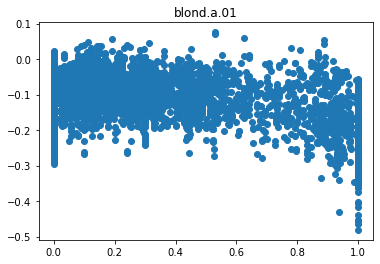

-0.4018016134730944 1.3320353993164384e-185


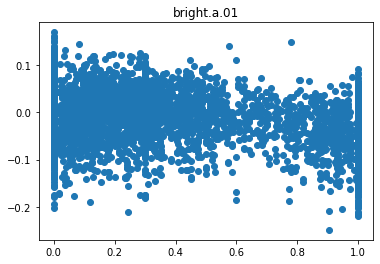

-0.4397804809116181 4.189065223522486e-226


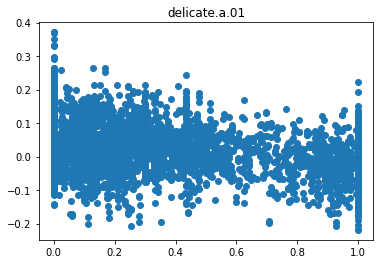

-0.5056407962247599 8.1583538378405e-310


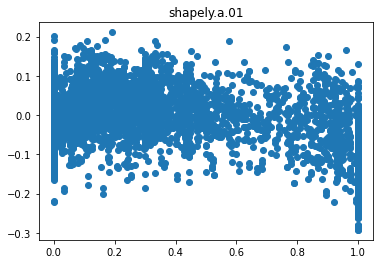

0.4883323501445118 5.238587506671958e-286


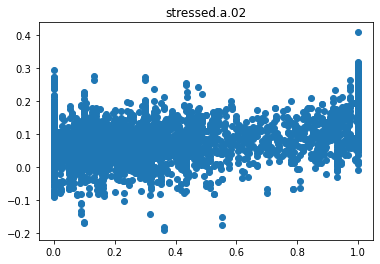

-0.44456186345283133 1.395441740701495e-231


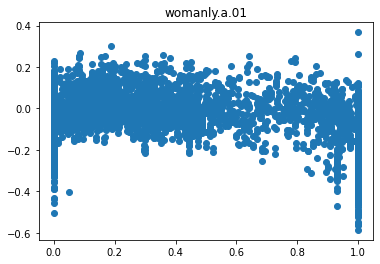

In [42]:
for pole in scores: 
    s = scores[pole]
    x = [] # gender
    y = [] # scores
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        if term in gender_labels: 
            x.append(gender_labels[term])
            y.append(s[i])
    corr, pval = stats.pearsonr(x, y)
    if corr > 0.4 or corr < -0.4: 
        print(corr, pval)
        plt.scatter(x, y)
        plt.title(pole)
        plt.show()